# Principal component analysis and PERMANOVA

## PERMANOVA

load libraries

In [1]:
library(ggfortify)
library(ggplot2)
library(ggsci)
library(gridExtra)
library(rlang)
library(vegan)
library(viridis)

Warning message:
“package ‘ggfortify’ was built under R version 3.6.2”
Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘rlang’ was built under R version 3.6.2”
Loading required package: permute

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 3.6.2”
This is vegan 2.5-6

Loading required package: viridisLite



load feature table

In [2]:
ft <- read.csv('PPG_KMF_resultingdatamatrix_GNPS.csv',sep = ";", header =TRUE, dec = ".", check.names = FALSE)

if (length(which(is.na(colSums(ft)))) != 0){
    ft <- ft[,-which(is.na(colSums(ft)))]
}

load metadata table

In [4]:
md <- read.table('metadata.txt', sep = '\t', header = T)

In [6]:
colnames(ft) <- gsub(' filtered Peak area','',colnames(ft))

In [7]:
colnames(ft)[-which(colnames(ft) %in% md$filename)]

[1] "row ID"             "row m/z"            "row retention time"

In [8]:
ft <- ft[,-c(2:3)]
ft <- t(ft)
colnames(ft) <- ft[1,]
ft <- ft[-1,]
class(ft) <-"numeric"

In [10]:
ft[ft==0] <- NA

In [11]:
md <- md[match(rownames(ft),md$filename),]
identical(as.character(md$filename),as.character(rownames(ft)))

[1] TRUE

run PERMANOVAs

In [12]:
distmetrics <- c('euclidean','bray','jaccard','canberra')

In [13]:
md <- md[which(md$filename%in%rownames(ft)),]
md <- md[match(rownames(ft),md$filename),]

In [14]:
sels <- c('ATTRIBUTE_injOrder',
          'ATTRIBUTE_type',
          'ATTRIBUTE_ACAT',
          'ATTRIBUTE_XX',
          'ATTRIBUTE_BW',
          'ATTRIBUTE_GA',
          'ATTRIBUTE_AAS',
          'ATTRIBUTE_MoB')

clean metadata 

In [15]:
for (i in 1:length(sels)){
    
    if('na' %in% names(table(md[,which(colnames(md) == sels[i])], exclude = NULL))){
        
        md[,which(colnames(md) == sels[i])][which(md[,which(colnames(md) == sels[i])] == 'na')] <- NaN
        md[,which(colnames(md) == sels[i])] <- droplevels(md[,which(colnames(md) == sels[i])])
    }
}

In [16]:
md$ATTRIBUTE_BW <- as.numeric(as.character(md$ATTRIBUTE_BW))
md$ATTRIBUTE_GA <- as.numeric(as.character(md$ATTRIBUTE_GA))
md$ATTRIBUTE_AAS <- as.numeric(as.character(md$ATTRIBUTE_AAS))

In [17]:
ft_nopools <- ft[-which(rownames(ft) %in% as.character(md$filename[which(md$ATTRIBUTE_type == 'Pool')])),]

In [18]:
md_nopools <- md[match(rownames(ft_nopools),md$filename),]

In [19]:
identical(as.character(md_nopools$filename), rownames(ft_nopools)) 

[1] TRUE

In [20]:
Rsqs <- c()
pvals <- c()

for (j in 1:length(distmetrics)){
    
    for (i in 1:length(sels)){
        
        catcor <- sels[i]
        message(catcor)

        distm <- vegdist(ft_nopools,method = distmetrics[j], na.rm = T)
        message(distmetrics[j])

        if (length(which(is.na(md_nopools[,colnames(md_nopools) == catcor]))) !=0){
            
            red <- as.dist(as.matrix(distm)[-which(is.na(md_nopools[,colnames(md_nopools) == catcor])),-which(is.na(md_nopools[,colnames(md_nopools) == catcor]))])
            md_red <- md_nopools[-which(is.na(md_nopools[,colnames(md_nopools) == catcor])),]
            Rsq <- adonis(red ~ na.omit(md_red[,colnames(md_red) == catcor]))$aov.tab$R2[1]
            pval <- adonis(red ~ na.omit(md_red[,colnames(md_red) == catcor]))$aov.tab$'Pr(>F)'[1]
        
        } else {
            
            Rsq <- adonis(distm ~ md_nopools[,colnames(md_nopools) == catcor])$aov.tab$R2[1]
            pval <- adonis(distm ~ md_nopools[,colnames(md_nopools) == catcor])$aov.tab$'Pr(>F)'[1]
      
        }

        Rsqs <- c(Rsqs,Rsq)
        pvals <- c(pvals,pval)
        
  }
    
}

ATTRIBUTE_injOrder

euclidean

ATTRIBUTE_type

euclidean

ATTRIBUTE_ACAT

euclidean

ATTRIBUTE_XX

euclidean

ATTRIBUTE_BW

euclidean

ATTRIBUTE_GA

euclidean

ATTRIBUTE_AAS

euclidean

ATTRIBUTE_MoB

euclidean

ATTRIBUTE_injOrder

bray

ATTRIBUTE_type

bray

ATTRIBUTE_ACAT

bray

ATTRIBUTE_XX

bray

ATTRIBUTE_BW

bray

ATTRIBUTE_GA

bray

ATTRIBUTE_AAS

bray

ATTRIBUTE_MoB

bray

ATTRIBUTE_injOrder

jaccard

ATTRIBUTE_type

jaccard

ATTRIBUTE_ACAT

jaccard

ATTRIBUTE_XX

jaccard

ATTRIBUTE_BW

jaccard

ATTRIBUTE_GA

jaccard

ATTRIBUTE_AAS

jaccard

ATTRIBUTE_MoB

jaccard

ATTRIBUTE_injOrder

canberra

ATTRIBUTE_type

canberra

ATTRIBUTE_ACAT

canberra

ATTRIBUTE_XX

canberra

ATTRIBUTE_BW

canberra

ATTRIBUTE_GA

canberra

ATTRIBUTE_AAS

canberra

ATTRIBUTE_MoB

canberra



In [21]:
out <- cbind(sels,Rsqs,pvals,rep(distmetrics,each = length(sels)))

In [22]:
out <- as.data.frame(out, stringsAsFactors = F)

In [23]:
colnames(out) <- c("metadata","AdonisR2","pvalue","metric")

In [25]:
out$AdonisR2 <- as.numeric(out$AdonisR2)
out$pvalue <- as.numeric(out$pvalue)

In [26]:
out$sig <- out$pvalue
out$sig[out$sig>=0.05] <- "p>0.05"
out$sig[out$sig<=0.05] <- "p<0.05"
out$sig <- as.factor(out$sig)

In [27]:
out$stars <- as.character(out$sig)
out$stars[which(out$stars == 'p>0.05')] <- ''
out$stars[which(out$stars == 'p<0.05')] <- '*'

In [28]:
keys <- cbind(sels, c('Injection order','ASD (yes/no)','ASD subtype', 'Gender','Birthweight',
      'Gestational age', 'Age at sampling','Month of birth'))
keys <- keys[order(keys[,1]),]

In [29]:
out$metadatanice <- keys[as.numeric(as.factor(out$metadata)),2]

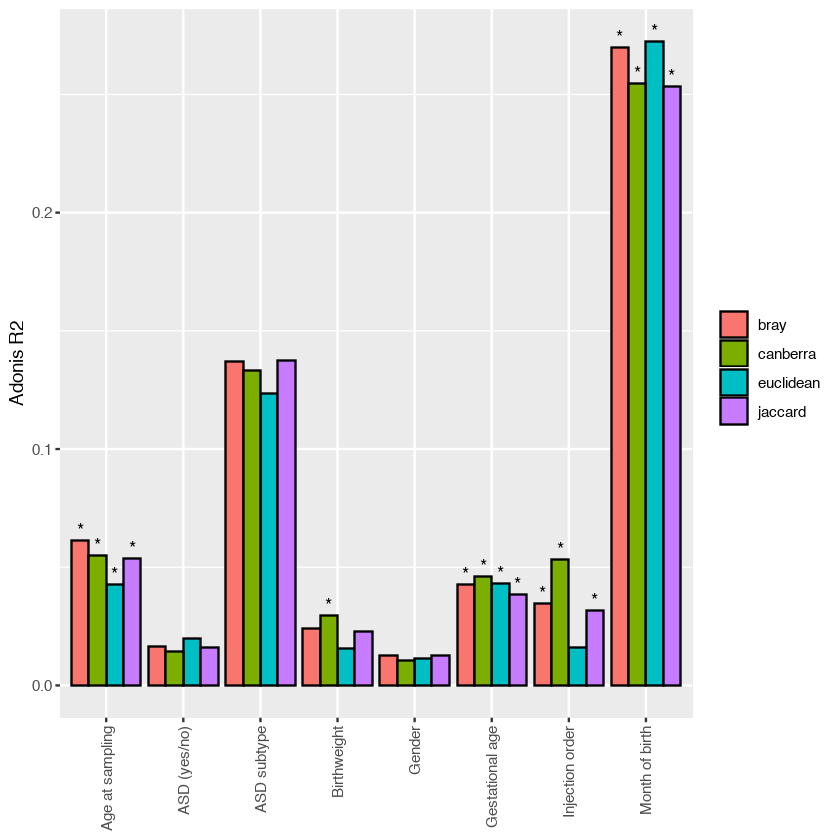

In [31]:
ggplot(out, aes(x=metadatanice, y=AdonisR2, fill=metric)) + 
    geom_bar(colour="black", stat="identity", position='dodge') +
    geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
    ggpubr::rotate_x_text() +
    labs(y= "Adonis R2") +
    theme(axis.title.x=element_blank(), legend.title = element_blank())

In [32]:
pdf(file="AdonisR2.pdf", width=5, height=5)
ggplot(out, aes(x=metadatanice, y=AdonisR2, fill=metric)) + 
    geom_bar(colour="black", stat="identity", position='dodge') +
    geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
    ggpubr::rotate_x_text() +
    labs(y= "Adonis R2") +
    theme(axis.title.x=element_blank(), legend.title = element_blank())
dev.off()

pdf 
  2

In [33]:
write.table(out, 'PERMANOVA_Summary.txt' ,sep = '\t', quote = F, row.names = F)

Assess sparsity of featuretable

In [34]:
length(which(is.na(ft_nopools)))/length(ft_nopools)

[1] 0.3324609

# PCA plots

In [35]:
df <- cbind(ft, md)

In [36]:
dim(df)

[1]   72 1324

In [37]:
dim(ft)

[1]   72 1281

In [38]:
dim(md)

[1] 72 43

In [39]:
ff <- df[,1:1281]
ff[which(is.na(ff), arr.ind = T)] <- 0

do PCA

In [40]:
pca_res <- prcomp(ff)

## Figure 3

In [41]:
cols <- c('#a80347','#ffcd82',
          '#808080')

In [42]:
pval_sel <- out[which(out$metric == 'euclidean' & out$metadata == 'ATTRIBUTE_type'),]$pvalue
Rsq_sel <- out[which(out$metric == 'euclidean' & out$metadata == 'ATTRIBUTE_type'),]$AdonisR2

Warning message:
“`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


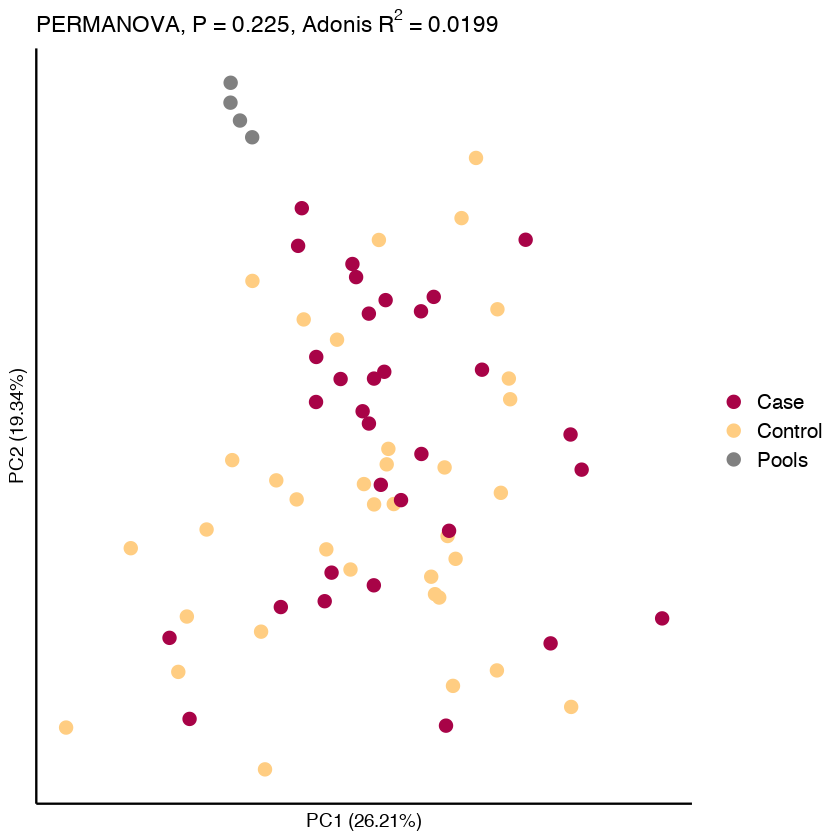

In [43]:
autoplot(pca_res, data = df, colour = 'ATTRIBUTE_type', size = 3) +
    scale_colour_manual(labels = c("Case", "Control", "Pools"), values = cols) +
    theme_classic() +
    theme(legend.title=element_blank(), axis.text.x = element_blank(), 
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          legend.text=element_text(size=12)) +
    ggtitle(expr(paste("PERMANOVA, ", "P = ", !!round(pval_sel,4),", Adonis " , R^2, " = ", !!round(Rsq_sel,4)))) 

In [44]:
pdf('Figure3.pdf',width=7,height=6)
autoplot(pca_res, data = df, colour = 'ATTRIBUTE_type', size = 3) +
    scale_colour_manual(labels = c("Case", "Control", "Pools"),values = cols) +
    theme_classic() +
    theme(legend.title=element_blank(), axis.text.x = element_blank(), 
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          legend.text=element_text(size=12)) +
    ggtitle(expr(paste("PERMANOVA, ", "P = ", !!round(pval_sel,4),", Adonis " , R^2, " = ", !!round(Rsq_sel,4)))) 
dev.off()

pdf 
  2

## Figure 4

In [45]:
cols <- c('#F8766D','#00BFC4')

In [46]:
df$ATTRIBUTE_MoB <- as.numeric(as.character(df$ATTRIBUTE_MoB))

In [47]:
sels_vip <- c('ATTRIBUTE_MoB','ATTRIBUTE_GA','ATTRIBUTE_AAS', 'ATTRIBUTE_XX')

In [48]:
plots <- list()
count <- 0
local(for (i in 1:length(sels_vip)){
    
    count <<- count + 1
    
    pval_sel <- out[which(out$metric == 'euclidean' & out$metadata == sels_vip[i]),]$pvalue
    Rsq_sel <- out[which(out$metric == 'euclidean' & out$metadata == sels_vip[i]),]$AdonisR2
    
    if (sels_vip[i] %in% c('ATTRIBUTE_MoB', 'ATTRIBUTE_GA', 'ATTRIBUTE_AAS')){
        
        Tr_PcoA <- autoplot(pca_res, data = df, colour = sels_vip[i], size = 3) +
                        scale_color_viridis(option = "D") +
                        theme_classic() +
                        theme(legend.title=element_blank(), axis.text.x = element_blank(), 
                              axis.text.y = element_blank(),axis.ticks = element_blank(),
                              legend.text=element_text(size=12)) +
                        ggtitle(expr(paste(!!keys[which(keys[,1] %in% sels_vip[i]),2], " (PERMANOVA, ", "P = ", !!round(pval_sel,4),", Adonis " , R^2, " = ", !!round(Rsq_sel,4), ")"))) 
    } else {
        
        
        Tr_PcoA <- autoplot(pca_res, data = df, colour = sels_vip[i], size = 3) +
                        scale_colour_manual(labels = c("Male", "Female", "Pools"), values = cols, na.value = "#808080") +
                        theme_classic() +
                        theme(legend.title=element_blank(), axis.text.x = element_blank(), 
                              axis.text.y = element_blank(),axis.ticks = element_blank(),
                              legend.text=element_text(size=12)) +
                        ggtitle(expr(paste(!!keys[which(keys[,1] %in% sels_vip[i]),2]," (PERMANOVA, ", "P = ", !!round(pval_sel,4),", Adonis " , R^2, " = ", !!round(Rsq_sel,4), ")"))) 

    }

      plots[[count]] <<- Tr_PcoA

})

In [49]:
pdf('Figure4.pdf',width=15,height=10)
grid.arrange(grobs = plots, ncol =2, widths =c(4,4))
dev.off()

pdf 
  2